Grayscale:


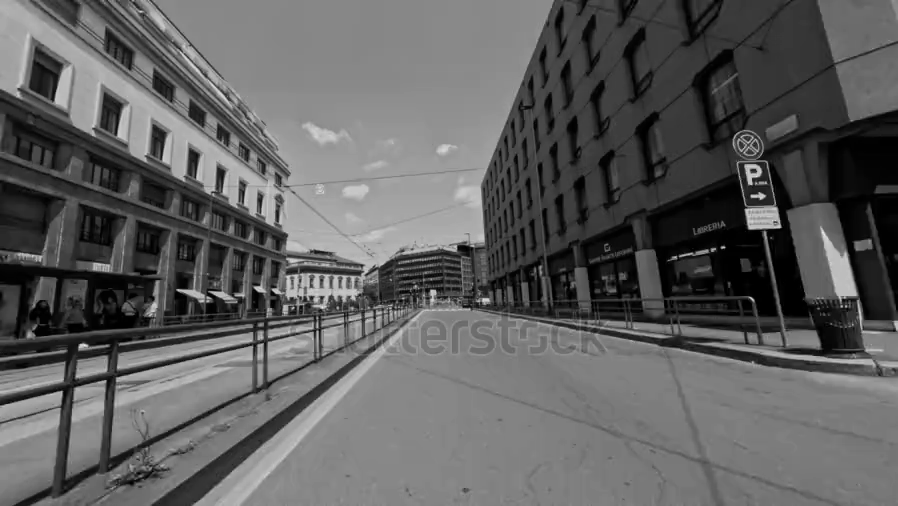

Blurred:


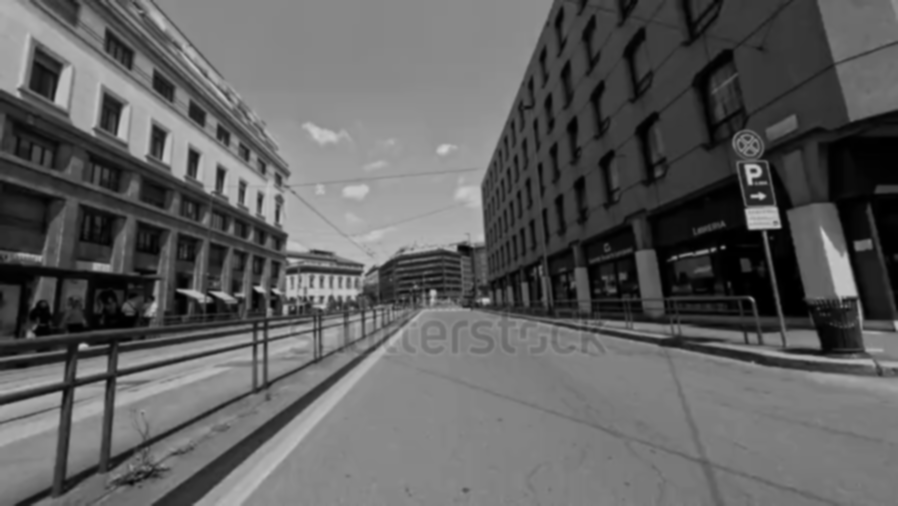

Canny Edges:


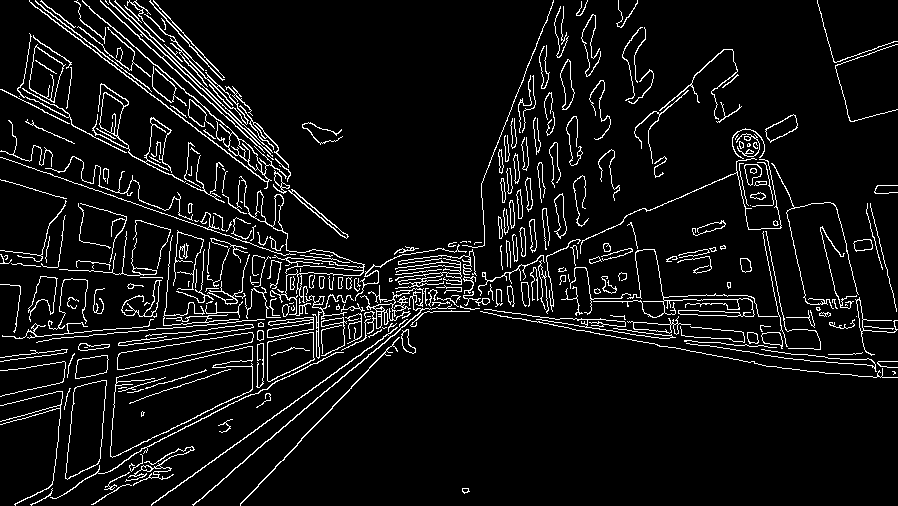

Masked Edges:


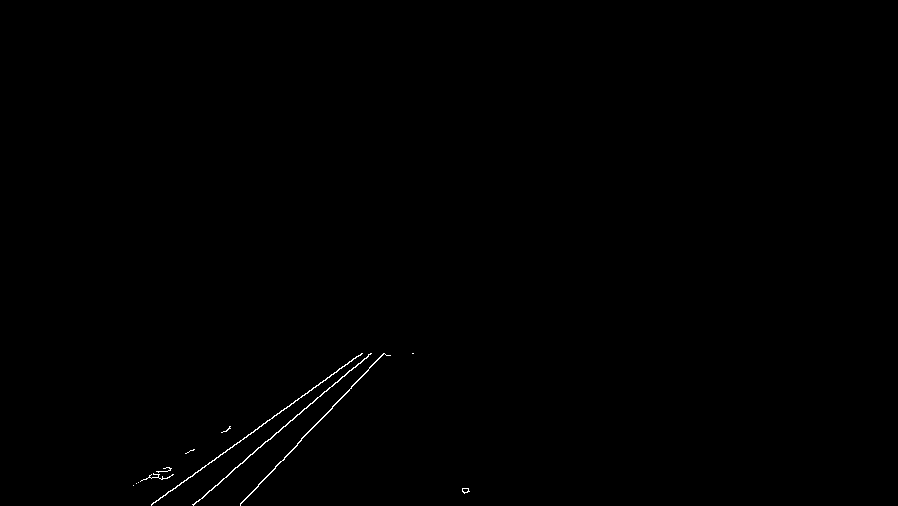

Detected Left Lane:


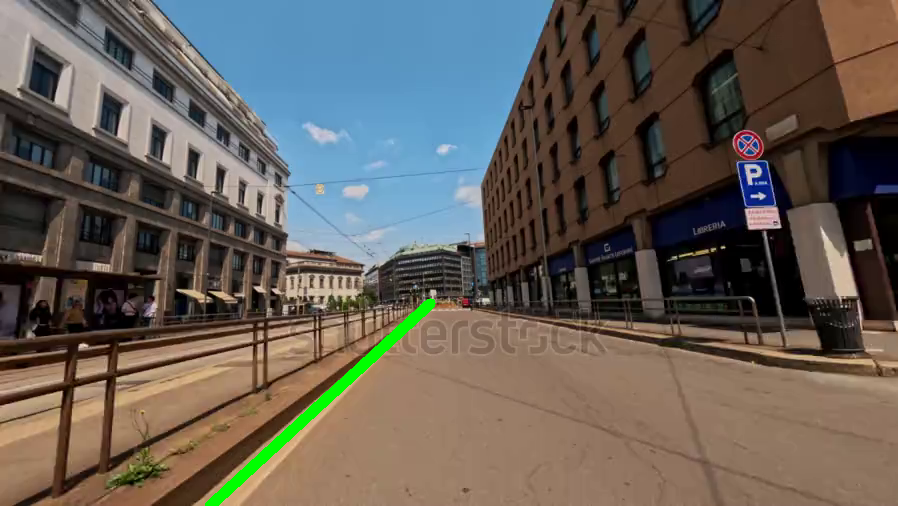

Detected Lanes:


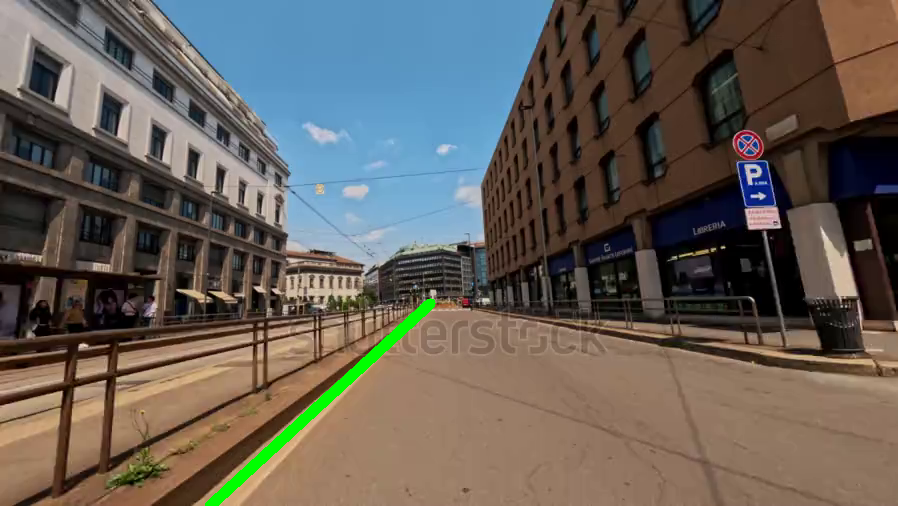

<ipython-input-6-407f20087423>:37: RankWarning: Polyfit may be poorly conditioned
  parameters = np.polyfit((x1, x2), (y1, y2), 1)
<ipython-input-6-407f20087423>:37: RankWarning: Polyfit may be poorly conditioned
  parameters = np.polyfit((x1, x2), (y1, y2), 1)
<ipython-input-6-407f20087423>:37: RankWarning: Polyfit may be poorly conditioned
  parameters = np.polyfit((x1, x2), (y1, y2), 1)


In [6]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def make_coordinates(image, line_parameters):
    try:
        slope, intercept = line_parameters
        y1 = image.shape[0]
        y2 = int(y1 * 3 / 5)
        x1 = int((y1 - intercept) / slope)
        x2 = int((y2 - intercept) / slope)
        return np.array([x1, y1, x2, y2], dtype=int)
    except:
        return np.array([0, 0, 0, 0], dtype=int)

def detect_lanes(frame):
    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    # Mask region of interest
    mask = np.zeros_like(edges)
    height, width = frame.shape[:2]
    region_of_interest_vertices = np.array([[(100, height), (width / 2 - 100, height / 2 + 100),
                                             (width / 2 + 100, height / 2 + 100), (width - 100, height)]], dtype=np.int32)
    cv2.fillPoly(mask, region_of_interest_vertices, 255)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Detect lines using Hough transform
    lines = cv2.HoughLinesP(masked_edges, 2, np.pi / 180, 100, np.array([]), minLineLength=40, maxLineGap=5)
    if lines is not None:
        left_lane_lines = []
        right_lane_lines = []
        for line in lines:
            x1, y1, x2, y2 = line[0]
            parameters = np.polyfit((x1, x2), (y1, y2), 1)
            slope = parameters[0]
            intercept = parameters[1]
            if slope < 0:
                left_lane_lines.append((slope, intercept))
            else:
                right_lane_lines.append((slope, intercept))

        # Average over all left and right slope and intercept to get a single line for each side
        if left_lane_lines:
            left_avg_line = np.average(left_lane_lines, axis=0)
            left_line = make_coordinates(frame, left_avg_line)
            #print("Left line coordinates:", left_line)  # Debugging
            if all(c != 0 for c in left_line) and all(0 <= c < max(frame.shape) for c in left_line):
                cv2.line(frame, (left_line[0], left_line[1]), (left_line[2], left_line[3]), (0, 255, 0), 10)

        if right_lane_lines:
            right_avg_line = np.average(right_lane_lines, axis=0)
            right_line = make_coordinates(frame, right_avg_line)
            #print("Right line coordinates:", right_line)  # Debugging
            if all(c != 0 for c in right_line) and all(0 <= c < max(frame.shape) for c in right_line):
                cv2.line(frame, (right_line[0], right_line[1]), (right_line[2], right_line[3]), (0, 255, 0), 10)

        return frame
    else:
        return frame

def process_video(input_video_path, output_video_path):
    cap = cv2.VideoCapture(input_video_path)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

    # Capture one frame for showing steps
    ret, frame = cap.read()
    if ret:
        # Show processing steps for the first frame
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        print("Grayscale:")
        cv2_imshow(gray)

        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        print("Blurred:")
        cv2_imshow(blurred)

        edges = cv2.Canny(blurred, 50, 150)
        print("Canny Edges:")
        cv2_imshow(edges)

        mask = np.zeros_like(edges)
        height, width = frame.shape[:2]
        region_of_interest_vertices = np.array([[(100, height), (width / 2 - 100, height / 2 + 100),
                                                 (width / 2 + 100, height / 2 + 100), (width - 100, height)]], dtype=np.int32)
        cv2.fillPoly(mask, region_of_interest_vertices, 255)
        masked_edges = cv2.bitwise_and(edges, mask)
        print("Masked Edges:")
        cv2_imshow(masked_edges)

        lines = cv2.HoughLinesP(masked_edges, 2, np.pi / 180, 100, np.array([]), minLineLength=40, maxLineGap=5)
        if lines is not None:
            left_lane_lines = []
            right_lane_lines = []
            for line in lines:
                x1, y1, x2, y2 = line[0]
                parameters = np.polyfit((x1, x2), (y1, y2), 1)
                slope = parameters[0]
                intercept = parameters[1]
                if slope < 0:
                    left_lane_lines.append((slope, intercept))
                else:
                    right_lane_lines.append((slope, intercept))

            if left_lane_lines:
                left_avg_line = np.average(left_lane_lines, axis=0)
                left_line = make_coordinates(frame, left_avg_line)
                if all(c != 0 for c in left_line) and all(0 <= c < max(frame.shape) for c in left_line):  # Ensure valid coordinates
                    cv2.line(frame, (left_line[0], left_line[1]), (left_line[2], left_line[3]), (0, 255, 0), 10)
                print("Detected Left Lane:")
                cv2_imshow(frame)

            if right_lane_lines:
                right_avg_line = np.average(right_lane_lines, axis=0)
                right_line = make_coordinates(frame, right_avg_line)
                if all(c != 0 for c in right_line) and all(0 <= c < max(frame.shape) for c in right_line):  # Ensure valid coordinates
                    cv2.line(frame, (right_line[0], right_line[1]), (right_line[2], right_line[3]), (0, 255, 0), 10)
                print("Detected Right Lane:")
                cv2_imshow(frame)

        print("Detected Lanes:")
        cv2_imshow(frame)

    # Process the rest of the video
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        processed_frame = detect_lanes(frame)
        out.write(processed_frame)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Process the input video and output the result
process_video('preview.mp4', 'output_video.mp4')
